In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.options.display.max_columns = 999
pd.options.display.max_rows = 50
%matplotlib inline
%load_ext nb_black

# project paths
project_root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
data_path = os.path.join(project_root_dir, "data")
image_path = os.path.join(project_root_dir, "images")
os.makedirs(image_path, exist_ok=True)
model_path = os.path.join(project_root_dir, "models")
os.makedirs(model_path, exist_ok=True)

# function for loading data
def load_data(filename, data_path=data_path):
    csv_path = os.path.join(data_path, filename)
    return pd.read_csv(csv_path)


def save_model(model, model_name, path=model_path):
    """This function save the trained model in pickle format"""
    path = os.path.join(model_path, model_name)
    joblib.dump(model, path)


def load_model(model_name, path=model_path):
    """This function loads the model"""
    model_to_load = os.path.join(model_path, model_name)
    return joblib.load(model_to_load)


# function for saving data as csv file
def save_dataframe(df, filename, file_path=data_path):
    """
    This function takes a dataframe and save it as a csv file.
    """
    path = os.path.join(file_path, filename)
    df.to_csv(path, index=False)

<IPython.core.display.Javascript object>

In [2]:
# Read the data
X_train = load_data("train_values.csv")
y_train = load_data("train_labels.csv")
y_train = y_train["damage_grade"]
X_test = load_data("test_values.csv")
submission_format = load_data("submission_format.csv")

<IPython.core.display.Javascript object>

In [3]:
y_train.head()

0    3
1    2
2    3
3    2
4    3
Name: damage_grade, dtype: int64

<IPython.core.display.Javascript object>

In [4]:
# # merge the training data and select only the 40% of the data for training the model
# train = X_train.merge(y_train, left_on="building_id", right_on="building_id")
# train_40 = train.sample(frac=0.4, random_state=42, weights="damage_grade")
# print(train_40.shape)

<IPython.core.display.Javascript object>

In [5]:
# X_train = train_40.drop("damage_grade", axis=1)
# y_train = train_40["damage_grade"]

<IPython.core.display.Javascript object>

## Data Preprocessing

In [4]:
# select numerical columns
num_cols = X_train.select_dtypes(include=["number"]).columns.to_list()
num_cols.remove("building_id")


def num_to_cat_list(df, num_col_list, n_unique_val):
    """This function takes a pandas dataframe, a list of numerical columns
    and create a list of columns that needs to be converted to categorical column if
    it is less than or equal to n_unique_val."""

    # columns that needs to converted
    cols_to_convert = []
    for col in num_col_list:
        unique_val = df[col].nunique()
        if unique_val <= n_unique_val:
            cols_to_convert.append(col)
    return cols_to_convert


a_list = num_to_cat_list(X_train, num_cols, 15)
# convert these columns to categorical
for col in a_list:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")
num_cols = X_train.select_dtypes(include=["number"]).columns.to_list()
num_cols.remove("building_id")
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numerical columns pipeline
num_pipeline = Pipeline(
    [
        ("num_imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ]
)

# categorical columns pipeline
cat_pipeline = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ]
)

# full pipeline
full_pipeline = ColumnTransformer(
    [("num", num_pipeline, num_cols), ("cat", cat_pipeline, cat_cols),]
)

# fit and transform the data sets
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

# Get the list of categories generated by the one-hot-encoder
ohe_categories = full_pipeline.named_transformers_["cat"]["one_hot_encoder"].categories_
# Create nice names for our one hot encoded features
new_ohe_features = [
    f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals
]

# Create a new list with all names of features
all_features = num_cols + new_ohe_features

# Create pandas dataframe
X_train = pd.DataFrame(X_train, columns=all_features)
X_test = pd.DataFrame(X_test, columns=all_features)

<IPython.core.display.Javascript object>

In [5]:
X_train.shape

(260601, 107)

<IPython.core.display.Javascript object>

In [6]:
X_test.shape

(86868, 107)

<IPython.core.display.Javascript object>

In [9]:
# # important features from the previous rf model
# df = load_data("X_train_imp.csv")
# df.head()

<IPython.core.display.Javascript object>

In [10]:
# df.columns.tolist()

<IPython.core.display.Javascript object>

In [11]:
# # only select the important features
# X_train_rf_imp = X_train[df.columns.tolist()]
# X_test_rf_imp = X_test[df.columns.tolist()]

<IPython.core.display.Javascript object>

## Gradient Boosting

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_train)
balanced_accuracy_score(y_train, xgb_pred)

0.6548378719083751

<IPython.core.display.Javascript object>

In [13]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_train)
balanced_accuracy_score(y_train, lgbm_pred)

0.6192738996069512

<IPython.core.display.Javascript object>

In [14]:
# cross-validation
from sklearn.model_selection import cross_val_score
xgb = XGBClassifier()
scores = cross_val_score(xgb, X_train, y_train, cv=3, scoring="accuracy")
scores

array([0.72703098, 0.7303579 , 0.72788286])

<IPython.core.display.Javascript object>

### Make a submission

In [15]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred_test = xgb.predict(X_test)
submission_format['damage_grade'] = xgb_pred_test
save_dataframe(submission_format, "xgb_basic_sub.csv")

<IPython.core.display.Javascript object>

So without doing any hyper parameter tunning, xgb model beats all the previous models and gets a accuracy of 72%. Let's also test the lightgbm library. 

In [16]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_pred_test = lgbm.predict(X_test)
submission_format['damage_grade'] = lgbm_pred_test
save_dataframe(submission_format, "lgbm_basic_sub.csv")

<IPython.core.display.Javascript object>

This lgbm model also performed well and has a accuracy of more than 71%.  

Another great thing about these models is that they are not overfitting the data as compared to decision tree and random forest models. The performanec on the test
set is higher than the performance on the training set. 

### Hyperparameter Optimization

In [21]:
from sklearn.model_selection import GridSearchCV

<IPython.core.display.Javascript object>

In [22]:
param_grid = {"learning_rate": [.2, .1, .05, .02, .01, .001],
             "max_depth": np.arange(1,10)}
xgb = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(xgb, param_grid=param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

<IPython.core.display.Javascript object>

In [23]:
grid_search_xgb.best_score_

0.7357799854950672

<IPython.core.display.Javascript object>

In [24]:
grid_search_xgb.best_params_

{'learning_rate': 0.2, 'max_depth': 9}

<IPython.core.display.Javascript object>

In [25]:
results = pd.DataFrame(grid_search_xgb.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,42.279112,0.755438,0.475378,0.031850,0.2,1,"{'learning_rate': 0.2, 'max_depth': 1}",0.638620,0.639265,0.639080,0.638988,0.000271,43,0.639426,0.638735,0.638620,0.638927,0.000356
1,71.882827,0.534868,0.554775,0.018517,0.2,2,"{'learning_rate': 0.2, 'max_depth': 2}",0.671682,0.673904,0.674053,0.673213,0.001084,29,0.673466,0.675009,0.673604,0.674027,0.000697
2,123.967854,25.586348,0.833773,0.139809,0.2,3,"{'learning_rate': 0.2, 'max_depth': 3}",0.685922,0.687960,0.689537,0.687806,0.001480,20,0.690055,0.688835,0.689623,0.689504,0.000505
3,188.655835,7.762195,1.117910,0.137830,0.2,4,"{'learning_rate': 0.2, 'max_depth': 4}",0.699000,0.699529,0.700646,0.699725,0.000686,13,0.704825,0.703046,0.704681,0.704184,0.000807
4,231.427380,3.668417,1.293705,0.048553,0.2,5,"{'learning_rate': 0.2, 'max_depth': 5}",0.710086,0.710293,0.710454,0.710277,0.000151,8,0.720274,0.718253,0.718622,0.719049,0.000879


<IPython.core.display.Javascript object>

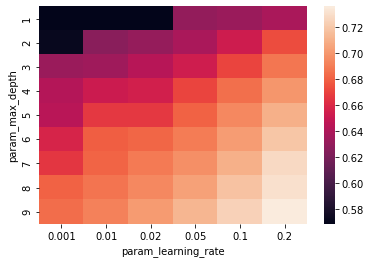

<IPython.core.display.Javascript object>

In [35]:
sns.heatmap(pd.pivot_table(results, index='param_max_depth', columns='param_learning_rate', values='mean_test_score'));

Looking at the heatmap, it feels like we can improve the results further if we increase the max depth and learning rate beyond 9 and 0.2 respectively. 
But Let's make one submission then we will do that. 

In [36]:
xgb_hyper1_pred = grid_search_xgb.best_estimator_.predict(X_test)
submission_format['damage_grade'] = xgb_hyper1_pred
save_dataframe(submission_format, "xgb_hyper1.csv")

<IPython.core.display.Javascript object>

In [45]:
from xgboost import plot_importance

<IPython.core.display.Javascript object>

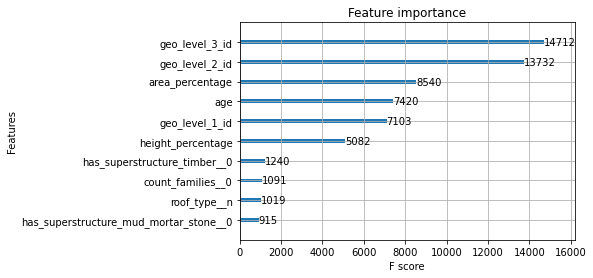

<IPython.core.display.Javascript object>

In [47]:
plot_importance(grid_search_xgb.best_estimator_ , max_num_features=10);

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {"learning_rate": [.1, .2, .3, .4, .5, .6],
             "max_depth": np.arange(8,16)}
xgb = XGBClassifier(random_state=42)
grid_search_xgb2 = GridSearchCV(xgb, param_grid=param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search_xgb2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

<IPython.core.display.Javascript object>

In [9]:
grid_search_xgb2.best_score_

0.7411291591359971

<IPython.core.display.Javascript object>

In [10]:
grid_search_xgb2.best_params_

{'learning_rate': 0.4, 'max_depth': 9}

<IPython.core.display.Javascript object>

In [11]:
results2 = pd.DataFrame(grid_search_xgb2.cv_results_)
results2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,343.365277,35.501427,1.726469,0.356074,0.1,8,"{'learning_rate': 0.1, 'max_depth': 8}",0.715588,0.719675,0.718685,0.717983,0.001741,48,0.742060,0.741237,0.742635,0.741977,0.000574
1,477.227097,26.318267,2.970382,0.513117,0.1,9,"{'learning_rate': 0.1, 'max_depth': 9}",0.723600,0.725580,0.724683,0.724621,0.000810,47,0.761037,0.759425,0.760577,0.760346,0.000678
2,604.604314,28.267904,5.808175,0.601670,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",0.728263,0.730692,0.728435,0.729130,0.001107,43,0.780567,0.777148,0.780141,0.779285,0.001521
3,600.810339,78.420206,5.093407,1.895780,0.1,11,"{'learning_rate': 0.1, 'max_depth': 11}",0.730116,0.734813,0.732660,0.732530,0.001920,39,0.798957,0.799797,0.799659,0.799471,0.000368
4,644.977115,26.846206,6.660598,0.665107,0.1,12,"{'learning_rate': 0.1, 'max_depth': 12}",0.734571,0.737622,0.735331,0.735841,0.001297,33,0.819563,0.819966,0.821520,0.820350,0.000844


<IPython.core.display.Javascript object>

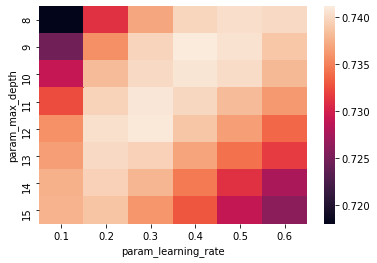

<IPython.core.display.Javascript object>

In [12]:
sns.heatmap(pd.pivot_table(results2, index='param_max_depth', columns='param_learning_rate', values='mean_test_score'));

In [13]:
# make a submission
xgb_hyper2_pred = grid_search_xgb2.best_estimator_.predict(X_test)
submission_format['damage_grade'] = xgb_hyper2_pred
save_dataframe(submission_format, "xgb_hyper2.csv")

<IPython.core.display.Javascript object>

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators": [100, 200, 300, 400, 500]}
xgb = XGBClassifier(learning_rate = 0.4, max_depth = 9, random_state=42)
grid_search_xgb3 = GridSearchCV(xgb, param_grid=param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search_xgb3.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.4, max_delta_step=None,
                                     max_depth=9, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, valid

<IPython.core.display.Javascript object>

In [11]:
grid_search_xgb3.best_score_

0.7425681405673809

<IPython.core.display.Javascript object>

In [12]:
grid_search_xgb3.best_params_

{'n_estimators': 200}

<IPython.core.display.Javascript object>

In [13]:
# make a submission
xgb_hyper3_pred = grid_search_xgb3.best_estimator_.predict(X_test)
submission_format['damage_grade'] = xgb_hyper3_pred
save_dataframe(submission_format, "xgb_hyper3.csv")

<IPython.core.display.Javascript object>

In [14]:
grid_search_xgb3.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

### Voting Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

<IPython.core.display.Javascript object>

In [22]:
rnd_forest = RandomForestClassifier(criterion= 'gini',max_depth=19, max_features= 'sqrt',min_samples_leaf= 11,min_samples_split= 19,n_estimators= 469)
lightgbm_clf = LGBMClassifier()
xgb_clf = XGBClassifier(learning_rate=0.4, max_depth=9, n_estimators=200)

voting_clf = VotingClassifier(
    estimators=[('rf', rnd_forest), ('light', lightgbm_clf), ('xgb', xgb_clf)],
    voting='hard'
)
scores = cross_val_score(voting_clf, X_train, y_train, cv=3)
scores

array([0.71919141, 0.72011236, 0.7211254 ])

<IPython.core.display.Javascript object>

In [23]:
scores.mean()

0.7201430539406987

<IPython.core.display.Javascript object>

The voting classifier is performing very bad. Let's try stacking. 

## Stacking 

In [26]:
# create a training and a validation set from the training set
from sklearn.model_selection import train_test_split
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=.3, random_state=42)

<IPython.core.display.Javascript object>

In [27]:
# train all the estimators on the training data
rnd_forest = RandomForestClassifier(criterion= 'gini',max_depth=19, max_features= 'sqrt',min_samples_leaf= 11,min_samples_split= 19,n_estimators= 469)
lightgbm_clf = LGBMClassifier()
xgb_clf = XGBClassifier(learning_rate=0.4, max_depth=9, n_estimators=200)

estimators = [rnd_forest, lightgbm_clf, xgb_clf]

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train1, y_train1)

Training the RandomForestClassifier(max_depth=19, max_features='sqrt', min_samples_leaf=11,
                       min_samples_split=19, n_estimators=469)
Training the LGBMClassifier()
Training the XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.4, max_delta_step=None, max_depth=9,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


<IPython.core.display.Javascript object>

In [28]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.672234941993579, 0.711707448101201, 0.7408193806679372]

<IPython.core.display.Javascript object>

In [29]:
# use this trained estimators to make predictions on the validation set
X_val_predictions = np.empty((len(X_valid), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_valid)

<IPython.core.display.Javascript object>

In [30]:
# now use these predictions as a training data for the second stage
xgb_blender = XGBClassifier(learning_rate=0.4, max_depth=9, n_estimators=200)
xgb_blender.fit(X_val_predictions, y_valid)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [33]:
# Now For each instances in the test set, make predictions with all the classifiers  

X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

<IPython.core.display.Javascript object>

In [34]:
# now feed the predictions from the test set to the blender to get the ensemble's predictions
y_pred = xgb_blender.predict(X_test_predictions)
y_pred[:5]

array([3, 2, 2, 2, 3])

<IPython.core.display.Javascript object>

In [35]:
# submit the predictions 
submission_format['damage_grade'] = y_pred
save_dataframe(submission_format, "stacking_pred.csv")

<IPython.core.display.Javascript object>

Ok, it did performed well but could not able to beat our previous tunned xgboost model. One reason might be the rf model. The performance of the rf model was not 
good. Let's remove this model and do the stacking again.

In [36]:
# train all the estimators on the training data
lightgbm_clf = LGBMClassifier()
xgb_clf = XGBClassifier(learning_rate=0.4, max_depth=9, n_estimators=200)

estimators = [lightgbm_clf, xgb_clf]

for estimator in estimators:
    estimator.fit(X_train1, y_train1)
    
# use this trained estimators to make predictions on the validation set
X_val_predictions = np.empty((len(X_valid), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_valid)
    
# now use these predictions as a training data for the second stage
xgb_blender = XGBClassifier(learning_rate=0.4, max_depth=9, n_estimators=200)
xgb_blender.fit(X_val_predictions, y_valid)


# Now For each instances in the test set, make predictions with all the classifiers  

X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
# now feed the predictions from the test set to the blender to get the ensemble's predictions
y_pred = xgb_blender.predict(X_test_predictions)

# submit the predictions 
submission_format['damage_grade'] = y_pred
save_dataframe(submission_format, "stacking_pred2.csv")

<IPython.core.display.Javascript object>

ok, we got the same result as before, removing rf model did not improve the performance. 

We will try one last thing in the next section. We will do some feature selection and then train the model with only those features. 